In [1]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pandas as pd
import contextily as ctx
from mplcairo import operator_t
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patheffects
import cartopy.crs as ccrs
import numpy as np
from math import floor
import matplotlib.patches as mpatches
mpl.rc('font', family='DejaVu Sans')

In [2]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        k = txt.get_text()
        try:
            txt.set_text(mapping[int(float(k))])
        except ValueError:
            pass

In [110]:
def get_bins(df, column, n_bins):
    min_v = df[column].min()
    max_v = df[column].max()
    array = []
    
    for i in range(n_bins+1):
        step = max_v/n_bins
        array.append(int(round(step*i, 0)))
    
    return array

def get_quantiles(df, column, k=5):
    step = 1/k
    quantiles = []
    for i in range(k+1):
        quantile_at_step = df[column].quantile(step*i)
        quantiles.append(quantile_at_step)
    return quantiles

In [56]:
lotes = gpd.read_file('./data/LOTES/lotes_completo.shp')
recorte_maior = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_maior.shp')
recorte_menor = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_menor.shp')
shoppings = gpd.read_file('./data/BASES/SHOPPINGS/shoppings.shp')

limite_mun = gpd.read_file("./data/BASES/limite_municipio/limite_municipio.shp")
recorte_maior = recorte_maior.to_crs(epsg=3857)
recorte_menor = recorte_menor.to_crs(epsg=3857)
lotes = lotes.to_crs(epsg=3857)
limite_mun = limite_mun.to_crs(epsg=3857)
lotes_recorte =  gpd.overlay(lotes, recorte_maior, how='intersection')
lotes =  gpd.overlay(lotes, limite_mun, how='intersection')

shoppings['classifica'] = 13
shoppings =  gpd.overlay(shoppings, limite_mun, how='intersection')

lotes = pd.concat([shoppings, lotes], join='outer')
shoppings_recorte =  gpd.overlay(shoppings, recorte_maior, how='intersection')
lotes_recorte = pd.concat([shoppings_recorte, lotes_recorte], join='outer')

In [174]:
def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.2, 0.1), linewidth=3,
              units='km', m_per_unit=1000):

    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
     #Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
                linewidth=linewidth, zorder=3)

In [233]:
def plot_categorical(df, 
                     column, 
                     borders, 
                     output, 
                     annotation_pos_1, 
                     annotation_pos_2, 
                     zoom, 
                     legend_title, 
                     scale_extension=1,
                     x_factor_left=1,
                     x_factor_right=1,
                     y_factor_bottom=1,
                     y_factor_top=1):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams["figure.figsize"] = (15,15)
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    #plt.style.use('ggplot')
    plt.rcParams['figure.facecolor'] = '#ffffff'
    plt.rcParams['figure.edgecolor'] = 'red'
    mpl.rcParams['legend.facecolor'] = '#ffffff'
    mpl.rcParams['figure.edgecolor'] = 'black'
    mpl.rcParams['legend.loc'] = 'lower center'


    colors = [
    '#80b1d3',
    '#8dd3c7',
    '#b3de69',
    '#ccebc5',
    '#ffed6f',
    '#ffffb3',
    '#e68d28',
    '#fdb462',
    '#fb8072',
    '#c897c9',
    '#bc80bd',
    '#a082a1',
    '#ff3333'
    ]


    fig, ax = plt.subplots( subplot_kw={'projection': ccrs.epsg(3857)})
    ax.set_facecolor('none')
    ax.set_axis_off()

    plot = df.plot(ax=ax, 
                   column=column, 
                   legend=True, 
                   cmap=mpl.colors.ListedColormap(colors),
                   categorical=True,
                   markersize=60,
                   legend_kwds={'loc': 'lower center',
                                'ncol': 7,
                                'title': legend_title,
                                'mode': 'expand',
                               'facecolor': 'white',
                  'framealpha': 1})

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    #example of how to zoomout by a factor of 0.1
    
    new_xlim_left = (xlim[0] + xlim[1])/2 + np.array((-0.5, 0.5)) * (xlim[1] - xlim[0]) * (x_factor_left) 
    new_xlim_right = (xlim[0] + xlim[1])/2 + np.array((-0.5, 0.5)) * (xlim[1] - xlim[0]) * (x_factor_right) 
    new_ylim_bottom = (ylim[0] + ylim[1])/2 + np.array((-0.5, 0.5)) * (ylim[1] - ylim[0]) * (y_factor_bottom)
    new_ylim_top = (ylim[0] + ylim[1])/2 + np.array((-0.5, 0.5)) * (ylim[1] - ylim[0]) * (y_factor_top)

    new_xlim_left = tuple(new_xlim_left)
    new_xlim_right = tuple(new_xlim_right)
    new_ylim_top = tuple(new_ylim_top)
    new_ylim_bottom = tuple(new_ylim_bottom)
    
    new_ylim = (new_ylim_bottom[0], new_ylim_top[1])
    new_xlim = (new_xlim_left[0], new_xlim_right[1])


    
    ax.set_xlim(new_xlim)
    ax.set_ylim(new_ylim)
    
    scale_bar(ax, ccrs.epsg(3857), scale_extension)

    
    #bairros.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.4, linestyle='--', alpha=0.5)
    for i, border in enumerate(borders):
        border_plot = border.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=(0.6+(i+1/2)), linestyle='--')

  

    plt.annotate('Base Cartográfica por Stamen Design', (0,0), 
                 annotation_pos_1, 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='center')
    
    plt.annotate('Fonte: Prefeitura de João Pessoa, 2020', 
                 (0,0), 
                 annotation_pos_2, 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='center')

    legend_dict={1: 'Alimentação',
                 2: 'Genêros Alimentícios',
                 3: 'Artigos do Lar',
                 4: 'Artigos Diversos',
                 5: 'Conveniência',
                 6: 'Vestuário',
                 7: 'Construção',
                 8: 'Automotivo',
                 9: 'Entretenimento',
                 10: 'Serviços Diversos',
                 11: 'Serviços Pessoais',
                 12: 'Serviços Médicos',
                 13: 'Shopping'}


    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, zoom=zoom, alpha = 0.2, attribution="")

    replace_legend_items(ax.get_legend(), legend_dict)
    #leg.set_bbox_to_anchor((0.5, -0.12))
    plt.tight_layout()
    legend = ax.get_legend()
    operator_t.MULTIPLY.patch_artist(plot) 
    operator_t.SOURCE.patch_artist(legend)  
    plt.savefig(output, bbox_inches='tight')
    

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f4ed7776bd0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


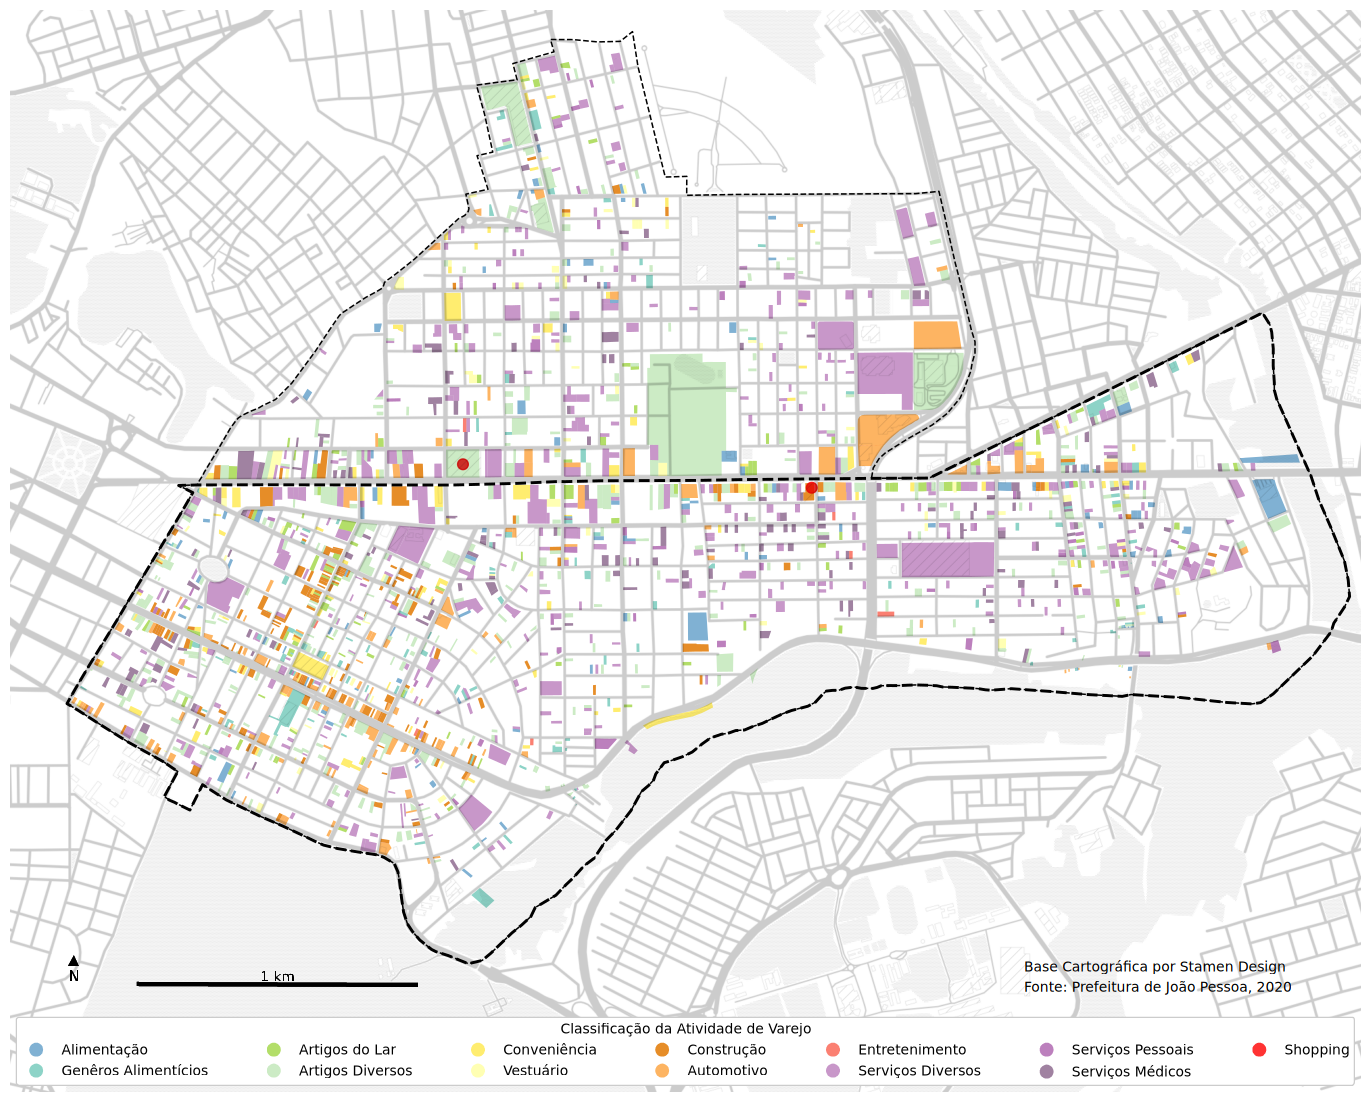

In [235]:
plot_categorical(lotes_recorte, 
                 'classifica', 
                 [recorte_maior, recorte_menor], 
                 'varejo_area_recorte.pdf', 
                 (730, 90), 
                 (730, 75), 
                 16, 
                 'Classificação da Atividade de Varejo',
                 y_factor_bottom=1.3,
                 x_factor_right=1)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f4ed781ebd0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


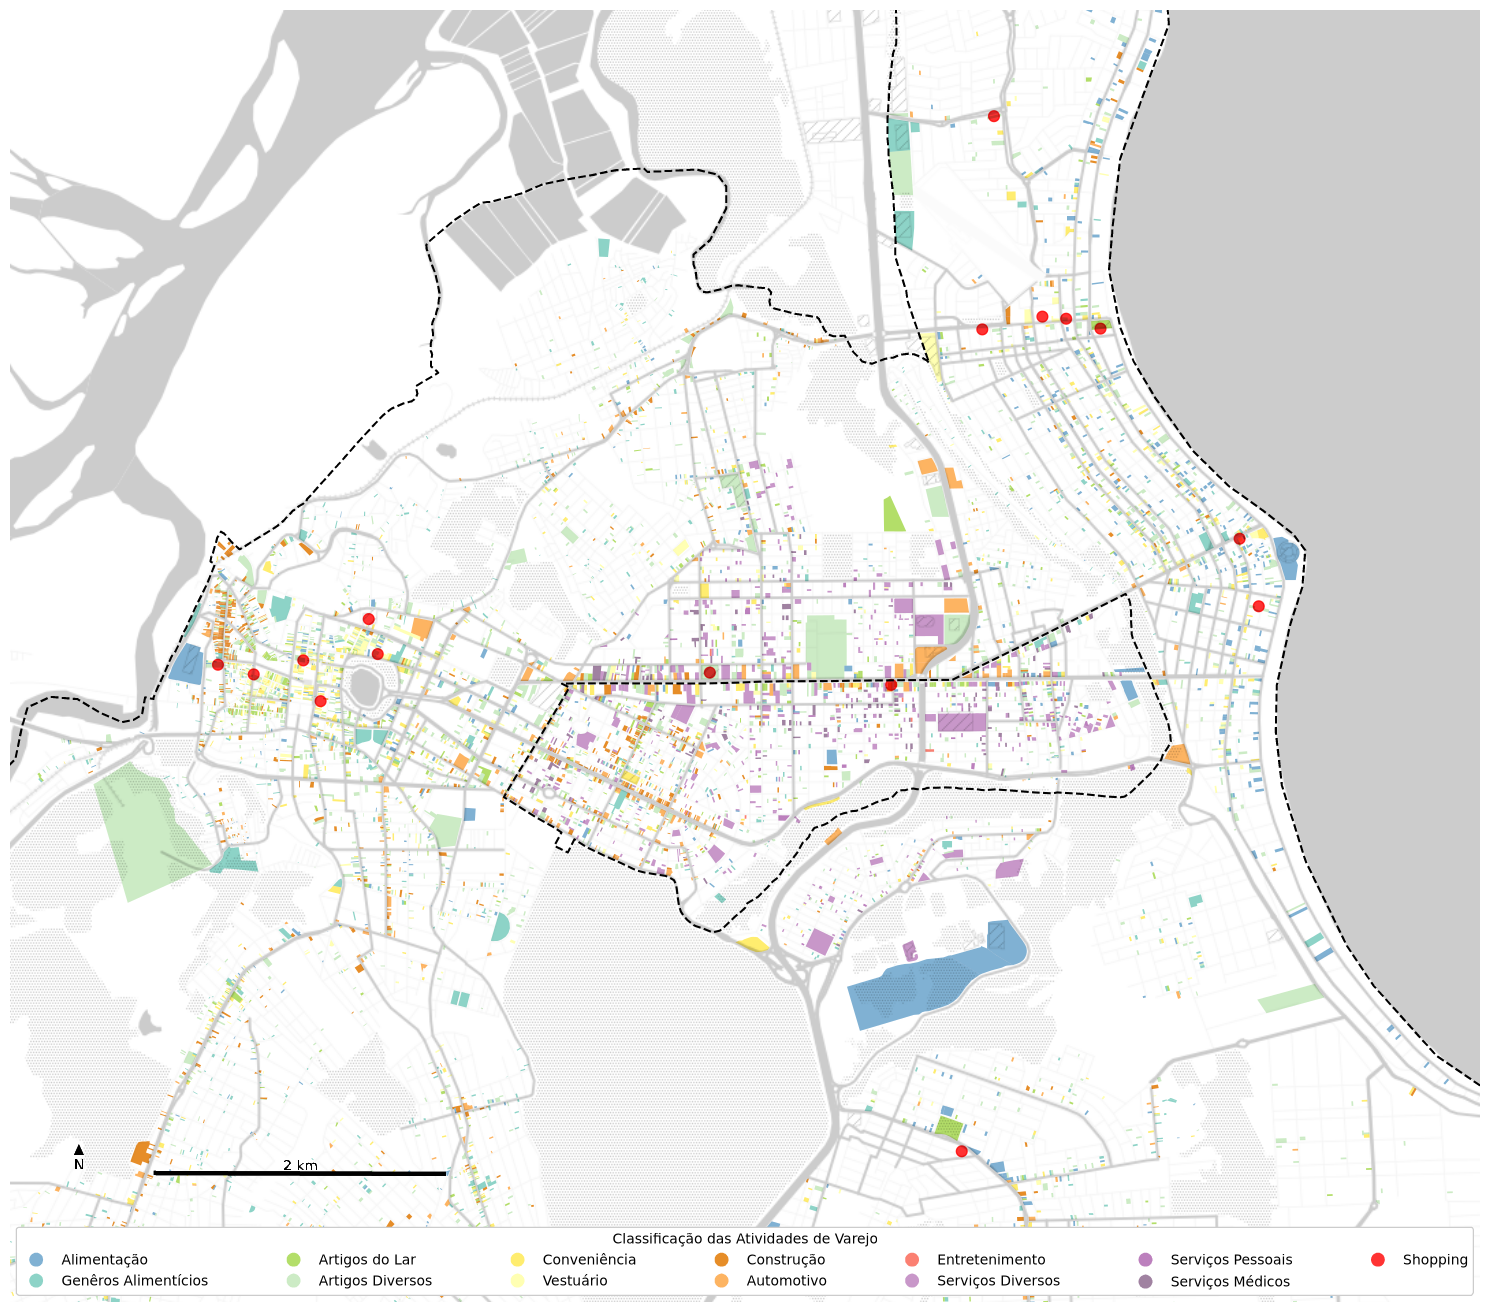

In [215]:
plot_categorical(lotes, 
                 'classifica', 
                 [limite_mun, recorte_menor], 
                 'comercio_cidade.pdf', 
                 (535, 27), (535, 10), 
                 14, 
                 'Classificação das Atividades de Varejo',
                 scale_extension=2,
                 y_factor_bottom=0.2,
                 y_factor_top=0.7,
                 x_factor_left=0.5,
                 x_factor_right=0.7)

In [ ]:
column = 'Area_Predi'
fig, ax = plt.subplots()
ax.set_facecolor('none')
ax.set_axis_off()
k = 10
alpha=0.8


shoppings.plot(ax=ax, color="red")
plot = lotes_recorte.plot(ax=ax, 
                          column=column, 
                          cmap='viridis',
                          linewidth=0,
                          scheme='quantiles', 
                          k=k,
                          edgecolor='#FFFFFF',
                          alpha=alpha)
cmap = mpl.cm.viridis
divider = make_axes_locatable(ax)
bins = get_quantiles(lotes_recorte, column, k=k)

norm = mpl.colors.BoundaryNorm(bins, cmap.N)

cax = divider.append_axes("bottom", size="5%", pad=0.05)

cb = mpl.colorbar.ColorbarBase(ax=cax,
                               cmap=cmap,
                               norm=norm,
                               spacing='uniform',
                               orientation='horizontal',
                               extend='neither',
                               ticks=bins,
                               drawedges=True,
                               alpha=alpha)



recorte_plot = recorte_maior.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.1, linestyle='--')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, zoom=16, alpha = 0.2, attribution="")
cb.outline.set_edgecolor('#ffffff')
cb.dividers.set_linewidth(3)
cax.tick_params(color='none')

plt.annotate('Fonte: Prefeitura de João Pessoa, 2020', (0,0), (740, 60), xycoords='axes fraction', textcoords='offset points', va='center')
plt.annotate('Base Cartográfica por Stamen Design', (0,0), (740, 75), xycoords='axes fraction', textcoords='offset points', va='center')
plt.annotate('(área em m²)', (0,0), (420, -30), xycoords='axes fraction', textcoords='offset points', va='center')

plt.tight_layout()
operator_t.MULTIPLY.patch_artist(plot)  # Use additive blending.
plt.savefig('varejo_area_construida.pdf', bbox_inches='tight')
plt.show()

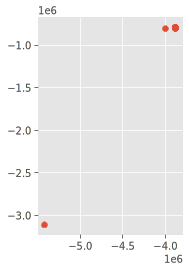